print SH "perl /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/run_and_parse_IDR.pl $entropyfi_rep1 $entropyfi_rep2 $IDRoutfi\n";
my $entropyfi_rep1 = $output_full_rep1.".compressed2.bed.full.annotated_proxdist.entropy";
my $entropyfi_rep2 = $output_full_rep2.".compressed2.bed.full.annotated_proxdist.entropy";
my $IDRoutfi = $idr_output_folder.$uid.".01v02.IDR.out";
um
ok that’s just the idr
then
perl /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/make_informationcontent_from_peaks.pl $idr_parsed_output_rep1full_annotated $mapped_num{$clip_fi1_short} $mapped_num{$input_fi_short}
perl /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/merge_idr_entropy.pl $merged_rep1_entropy $merged_rep2_entropy $uid
wait no i lost something in there
screw it
/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/compare_vs_input_peakbased_wrapper2_OneOrTwoRepVersion_PEbamfileversion_submit.pl is the pipeline


Use of uninitialized value $output_prefix in concatenation (.) or string at /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/get_reproducing_peaks.pl line 23.


perl /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/get_reproducing_peaks.pl 
/home/gpratt/projects/idr/analysis/eric_idr_test/IDR/209.01v02.IDR.out 
/home/gpratt/projects/idr/analysis/eric_idr_test/209_01.basedon_209_01.peaks.l2inputnormnew.bed.full.compressed2.bed.full.annotated_proxdist.entropy
/home/gpratt/projects/idr/analysis/eric_idr_test/209_02.basedon_209_02.peaks.l2inputnormnew.bed.full.compressed2.bed.full.annotated_proxdist.entropy 
/projects/ps-yeolab3/encode/analysis/encode_master/209_01_SRSF7.merged.r2.bam 
/projects/ps-yeolab3/encode/analysis/encode_master/209_02_SRSF7.merged.r2.bam
/projects/ps-yeolab3/encode/analysis/encode_master/Sample-209-input_S12_R1.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.r2.bam 
ALLDATASETS_submittedonly.txt.mapped_read_num 
/home/gpratt/projects/idr/analysis/eric_idr_test/IDR/209.01v02.IDR.out.0102merged


perl /home/elvannostrand/data/clip/CLIPseq_analysis/scripts/PIPELINE_EricVersion/compare_vs_input_peakbased_wrapper2_OneOrTwoRepVersion_PEbamfileversion_submit.pl all_idr_datasets.txt /home/gpratt/projects/idr/analysis/eric_style_idr hg19

In [1]:
%matplotlib inline

import glob
import os
import json

import gspread
from IPython.core.display import HTML
import numpy as np
from oauth2client.client import SignedJwtAssertionCredentials
import pandas as pd
import pybedtools
import seaborn as sns
import json
import sklearn

from gscripts.general import region_helpers
from gscripts.general import dataviz
import matplotlib as mpl
import datetime
img_dir ="/home/gpratt/Dropbox/encode_integration/for_eric/idr_qc/"

from gscripts.encode import encode_helpers

from tqdm import tqdm, tqdm_notebook
tqdm.pandas("Progress: ")

RESET = False

In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Get all datasets we will use in the final paper

In [3]:
input_norm_dir = "/projects/ps-yeolab3/encode/analysis/Eric_Input_Norm/"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v2/"
idr_dir = "/home/gpratt/projects/idr/analysis/idr_v3/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
frip_out_dir = "/home/gpratt/projects/encode/analysis/frip_calculations/"
downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

In [4]:
merged_data = encode_helpers.get_merged_data()

#Filter out anything sequenced after 16/7/18
merged_data = merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]
#Filter out any data we are planning on submitting, but haven't yet submitted
merged_data = merged_data[merged_data.annotation != "Submit"]

In [5]:
#Construct manifest to process data
rep_information = ['CLIP', 'input_norm']
temp_index = list(merged_data.columns.difference(rep_information))
idr_manifest = merged_data.set_index(temp_index, append=True)
idr_manifest = idr_manifest.unstack(level="rep")
idr_manifest = idr_manifest.reset_index()
idr_manifest = idr_manifest.set_index(merged_data.index.names[:-1])
idr_manifest['uID', ""] = idr_manifest.index.get_level_values("uID")

# Make basic IDR manifest
for my old pipeline, still need this to call peaks, Erics manifest is basically a finishing script

In [6]:
basic_idr = idr_manifest.reset_index()
basic_idr['genome'] = 'hg19'
basic_idr = basic_idr[[ ("CLIP", "rep1"), ("CLIP", "rep2"), 
                       ("INPUT", ""), 
                       ("genome", ""),
                       ("uID", ""),
                      ]]

half_size = len(basic_idr) / 2
basic_idr[:half_size].to_csv("/home/gpratt/projects/idr/scripts/idr_v2_condo.txt", sep="\t", index=False, header=False)
basic_idr[half_size:].to_csv("/home/gpratt/projects/idr/scripts/idr_v2_yeo.txt", sep="\t", index=False, header=False)
basic_idr.to_csv("/home/gpratt/projects/idr/scripts/idr_v2.txt", sep="\t", index=False, header=False)

# Make Erics IDR Manifest

In [7]:
pesudo_rep = idr_manifest[['CLIP','INPUT']]
pesudo_rep = pesudo_rep.swaplevel("Cell line", 'RBP')
pesudo_rep = pesudo_rep.reset_index()

pesudo_rep_1 = pesudo_rep.copy()
pesudo_rep_1['CLIP', 'rep1'] = pesudo_rep['CLIP', 'rep1'].apply(lambda x: os.path.join(split_dir, ".".join(os.path.basename(x).split(".")[:-1])) + ".01.bam")
pesudo_rep_1['CLIP', 'rep2'] = pesudo_rep['CLIP', 'rep1'].apply(lambda x: os.path.join(split_dir, ".".join(os.path.basename(x).split(".")[:-1])) + ".02.bam")
pesudo_rep_1.uID = pesudo_rep.uID + "_rep1"

pesudo_rep_2 = pesudo_rep.copy()
pesudo_rep_2['CLIP', 'rep1'] = pesudo_rep['CLIP', 'rep2'].apply(lambda x: os.path.join(split_dir, ".".join(os.path.basename(x).split(".")[:-1])) + ".01.bam")
pesudo_rep_2['CLIP', 'rep2'] = pesudo_rep['CLIP', 'rep2'].apply(lambda x: os.path.join(split_dir, ".".join(os.path.basename(x).split(".")[:-1])) + ".02.bam")
pesudo_rep_2.uID = pesudo_rep.uID + "_rep2"

combined_rep = pesudo_rep.copy()
combined_rep['CLIP', 'rep1'] = pesudo_rep.uID.apply(lambda x: os.path.join(split_dir, x + ".merged.01.bam"))
combined_rep['CLIP', 'rep2'] = pesudo_rep.uID.apply(lambda x: os.path.join(split_dir, x + ".merged.02.bam"))
combined_rep.uID = pesudo_rep.uID + "_combined"
all_idr = pd.concat([pesudo_rep_1, pesudo_rep_2, combined_rep])
all_idr.columns = ['uID', 'RBP', 'Cell line', 'CLIP_rep1', 'CLIP_rep2', 'INPUT']
all_idr.to_csv("/home/gpratt/projects/idr/analysis/eric_style_idr/all_idr_datasets.txt", index=False, sep="\t")

# Calculate IDR stats

In [11]:
idr_manifest['pesudoreplicate_merged'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_dir, x + ".combined.txt"))
idr_manifest['rep1_merged'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_dir, x + ".rep1.txt"))
idr_manifest['rep2_merged'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_dir, x + ".rep2.txt"))
idr_manifest['replicate_merged'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_dir, x + ".txt"))

In [13]:
idr_manifest = idr_manifest[idr_manifest.pesudoreplicate_merged.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.rep1_merged.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.rep2_merged.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.replicate_merged.apply(os.path.exists)]

In [16]:
idr_peaks_dir = "/home/gpratt/projects/idr/analysis/eric_style_idr/IDR/"
actual_peaks_dir = "/projects/ps-yeolab3/encode/analysis/Eric_IDR/"
idr_manifest['pesudoreplicate_merged_v2'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_peaks_dir, x + "_combined.01v02.IDR.out.0102merged.bed"))
idr_manifest['rep1_merged_v2'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_peaks_dir, x + "_rep1.01v02.IDR.out.0102merged.bed"))
idr_manifest['rep2_merged_v2'] = idr_manifest.uID.apply(lambda x: os.path.join(idr_peaks_dir, x + "_rep2.01v02.IDR.out.0102merged.bed"))
idr_manifest['replicate_merged_v2'] = idr_manifest.uID.apply(lambda x: os.path.join(actual_peaks_dir, x + ".01v02.IDR.out.0102merged.bed"))

In [18]:
idr_manifest = idr_manifest[idr_manifest.pesudoreplicate_merged_v2.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.rep1_merged_v2.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.rep2_merged_v2.apply(os.path.exists)]
idr_manifest = idr_manifest[idr_manifest.replicate_merged_v2.apply(os.path.exists)]

In [19]:
len(idr_manifest)

248

.01v02.IDR.out.0102merged.bed  

In [20]:
idr_manifest.ix['204'].T

,Cell line,HepG2
,RBP,RBFOX2
CLIP,rep,
,,
INPUT,,/projects/ps-yeolab3/encode/analysis/encode_ma...
Submitted Date,,2015-02-18 00:00:00
annotation,,
family,,
family_bound,,FALSE
family_mapping_submitable,,False
generally_submittable,,True


In [21]:
def make_significant_idr_peaks(fn):
    file_name, ext = os.path.splitext(fn)
    out_file = file_name + ".significant" + ext

    if os.path.exists(out_file) and not RESET:
        return out_file
    bedtool = pybedtools.BedTool(fn)
    bedtool = bedtool.filter(lambda x: float(x.score) > 540).sort().saveas(out_file)
    return out_file

idr_manifest['pesudoreplicate_sig'] = idr_manifest.pesudoreplicate_merged.progress_apply(make_significant_idr_peaks)
idr_manifest['rep1_sig'] = idr_manifest.rep1_merged.progress_apply(make_significant_idr_peaks)
idr_manifest['rep2_sig'] = idr_manifest.rep2_merged.progress_apply(make_significant_idr_peaks)
idr_manifest['replicate_sig'] = idr_manifest.replicate_merged.progress_apply(make_significant_idr_peaks)

100%|██████████| 248/248 [00:04<00:00, 55.40it/s]


In [22]:
def count_peaks(fn):
    try:
        bedtool = pybedtools.BedTool(fn)
        return len(bedtool)
    except Exception as e:
        print fn, e
        return 0
    
idr_manifest['pesudoreplicate_count'] = idr_manifest.pesudoreplicate_sig.progress_apply(count_peaks)
idr_manifest['rep1_count'] = idr_manifest.rep1_sig.progress_apply(count_peaks)
idr_manifest['rep2_count'] = idr_manifest.rep2_sig.progress_apply(count_peaks)
idr_manifest['replicate_count'] = idr_manifest.replicate_sig.progress_apply(count_peaks)

100%|██████████| 248/248 [02:59<00:00,  2.77it/s]


In [23]:
def count_peaks(fn):
    try:
        bedtool = pybedtools.BedTool(fn)
        return len(bedtool)
    except Exception as e:
        print fn, e
        return 0
    
idr_manifest['pesudoreplicate_count_v2'] = idr_manifest.pesudoreplicate_merged_v2.progress_apply(count_peaks)
idr_manifest['rep1_count_v2'] = idr_manifest.rep1_merged_v2.progress_apply(count_peaks)
idr_manifest['rep2_count_v2'] = idr_manifest.rep2_merged_v2.progress_apply(count_peaks)
idr_manifest['replicate_count_v2'] = idr_manifest.replicate_merged_v2.progress_apply(count_peaks)

100%|██████████| 248/248 [00:30<00:00,  8.26it/s]


In [24]:
#idr_manifest.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/idr_counts.csv")

In [25]:
def rescue_ratio(row, version=""):
    try:
        higher = float(max(row['pesudoreplicate_count' + version][0], row['replicate_count' + version][0])) 
        lower = float(min(row['pesudoreplicate_count' + version][0], row['replicate_count' + version][0]))
        return higher / lower

    except Exception as e:
        print e, row.uID[0]
        return np.nan

def self_consistency_ratio(row, version=""):
    try:
        higher = float(max(row['rep1_count' + version][0], row['rep2_count' + version][0])) 
        lower = float(min(row['rep1_count' + version][0], row['rep2_count' + version][0]))
        return higher / lower
    except Exception as e:
        print e, row.uID
        return np.nan

def reproducibility_test(row, version=""):
    if row['rescue_ratio' + version][0] < 2 and row['self_consistency_ratio' + version][0] < 2:
        return "pass"
    elif row['rescue_ratio' + version][0] < 2 or row['self_consistency_ratio' + version][0] < 2:
        return "borderline"
    else:
        return "fail"

In [26]:
from functools import partial

In [27]:
idr_manifest['rescue_ratio'] =  idr_manifest.apply(rescue_ratio, axis=1)
idr_manifest['self_consistency_ratio'] =  idr_manifest.apply(self_consistency_ratio, axis=1)
idr_manifest['reproducibility_test'] = idr_manifest.apply(reproducibility_test, axis=1)

rescue_ratio_v2 = partial(rescue_ratio, version="_v2")
self_consistency_ratio_v2 = partial(self_consistency_ratio, version="_v2")
reproducibility_test_v2 = partial(reproducibility_test, version="_v2")

idr_manifest['rescue_ratio_v2'] =  idr_manifest.apply(rescue_ratio_v2, axis=1)
idr_manifest['self_consistency_ratio_v2'] =  idr_manifest.apply(self_consistency_ratio_v2, axis=1)
idr_manifest['reproducibility_test_v2'] = idr_manifest.apply(reproducibility_test_v2, axis=1)

float division by zero 599
float division by zero 618


In [28]:
sns.set_style("ticks")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:4428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


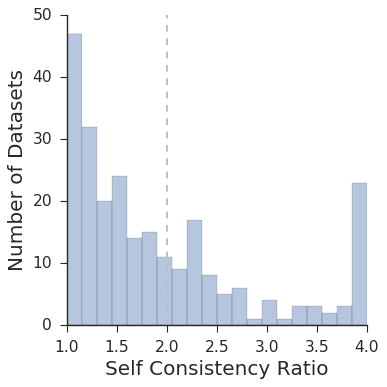

In [29]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "self_consistency_ratio_presentation.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dist = idr_manifest['self_consistency_ratio']
    dist[dist > 4] = 4
    sns.distplot(dist, kde=False, bins=20, ax=ax)

    sns.despine(ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=18)
    ax.set_xlabel("Self Consistency Ratio", fontsize=18)
    [tick.set_fontsize(14) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(14) for tick in ax.get_yticklabels()]
    ax.axvline(2, color='.75', linestyle="--")
                                

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


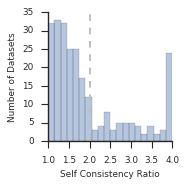

In [30]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "self_consistency_ratio_v2.svg"), figsize=(2.5 * num_cols,2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dist = idr_manifest['self_consistency_ratio_v2']
    dist[dist > 4] = 4
    sns.distplot(dist, kde=False, bins=20, ax=ax)

    sns.despine(ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=8)
    ax.set_xlabel("Self Consistency Ratio", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.axvline(2, color='.75', linestyle="--")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


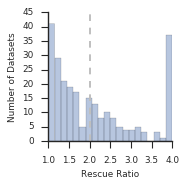

In [31]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rescue_ratio.svg"), figsize=(2.5 * num_cols,2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dist = idr_manifest.rescue_ratio
    dist[dist > 4] = 4
    sns.distplot(dist, kde=False, bins=20, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=8)
    ax.set_xlabel("Rescue Ratio", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
            
    ax.axvline(2, color='.75', linestyle="--")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


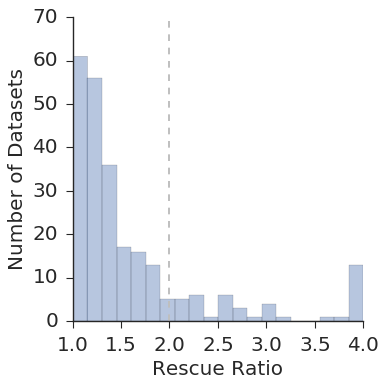

In [32]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rescue_ratio_v2.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dist = idr_manifest['rescue_ratio_v2']
    dist[dist > 4] = 4
    dist = dist.dropna()
    sns.distplot(dist, kde=False, bins=20, ax=ax)

    sns.despine(ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=18)
    ax.set_xlabel("Rescue Ratio", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.axvline(2, color='.75', linestyle="--")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


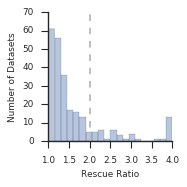

In [33]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rescue_ratio_v2.svg"), figsize=(2.5 * num_cols,2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    dist = idr_manifest['rescue_ratio_v2']
    dist[dist > 4] = 4
    dist = dist.dropna()
    sns.distplot(dist, kde=False, bins=20, ax=ax)

    sns.despine(ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=8)
    ax.set_xlabel("Rescue Ratio", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.axvline(2, color='.75', linestyle="--")

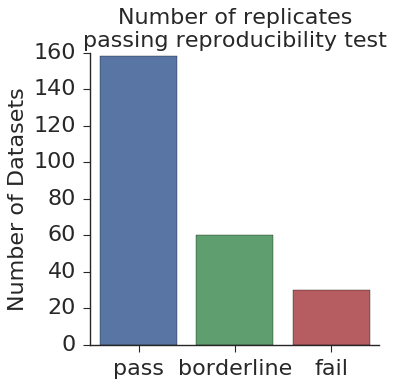

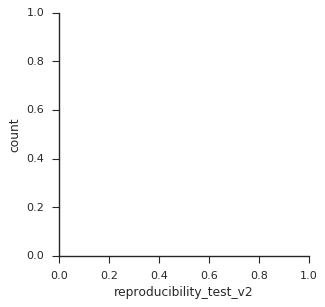

In [34]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_v2_presentation.svg"), figsize=(5* num_cols, 5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Reproducablity Test")
    ax.set_title("Number of replicates\npassing reproducibility test", fontsize=20)
    sns.despine(ax=ax)
    
    sns.factorplot(x='reproducibility_test_v2', 
                   kind='count', 
                   data=idr_manifest, 
                   order=["pass", "borderline", "fail"],
                   ax=ax
                  )
    ax.set_ylabel("Number of Datasets", fontsize=20)
    ax.set_xlabel("")
    [tick.set_fontsize(20) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(20) for tick in ax.get_yticklabels()]

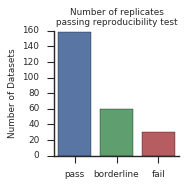

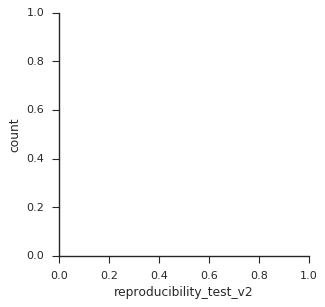

In [35]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_v2.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Reproducablity Test")
    ax.set_title("Number of replicates\npassing reproducibility test", fontsize=8)
    sns.despine(ax=ax)
    
    sns.factorplot(x='reproducibility_test_v2', 
                   kind='count', 
                   data=idr_manifest, 
                   order=["pass", "borderline", "fail"],
                   ax=ax
                  )
    ax.set_ylabel("Number of Datasets", fontsize=8)
    ax.set_xlabel("")
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

In [36]:
tp = len(idr_manifest[idr_manifest.generally_submittable & idr_manifest.reproducibility_test.isin(["pass"])])
fp = len(idr_manifest[~idr_manifest.generally_submittable & idr_manifest.reproducibility_test.isin(["pass"])])
fn = len(idr_manifest[idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test.isin(["pass"])])
tn = len(idr_manifest[~idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test.isin(["pass"])])
print tp, fp, fn, tn
print sklearn.metrics.f1_score(idr_manifest.generally_submittable, idr_manifest.reproducibility_test.isin(["pass"]))

93 13 89 53
0.645833333333


In [37]:
tp = len(idr_manifest[idr_manifest.generally_submittable& idr_manifest.reproducibility_test.isin(["pass", 'borderline'])])
fp = len(idr_manifest[~idr_manifest.generally_submittable & idr_manifest.reproducibility_test.isin(["pass", 'borderline'])])
fn = idr_manifest[idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test.isin(["pass", 'borderline'])]
tn = len(idr_manifest[~idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test.isin(["pass", 'borderline'])])
print tp, fp, len(fn), tn
print sklearn.metrics.f1_score(idr_manifest.generally_submittable, idr_manifest.reproducibility_test.isin(["pass", 'borderline']))

157 37 25 29
0.835106382979


In [38]:
tp = len(idr_manifest[idr_manifest.generally_submittable & idr_manifest.reproducibility_test_v2.isin(["pass"])])
fp = len(idr_manifest[~idr_manifest.generally_submittable & idr_manifest.reproducibility_test_v2.isin(["pass"])])
fn = len(idr_manifest[idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test_v2.isin(["pass"])])
tn = len(idr_manifest[~idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test_v2.isin(["pass"])])
print tp, fp, fn, tn
print sklearn.metrics.f1_score(idr_manifest.generally_submittable, idr_manifest.reproducibility_test_v2.isin(["pass"]))

134 24 48 42
0.788235294118


In [39]:
tp = len(idr_manifest[idr_manifest.generally_submittable& idr_manifest.reproducibility_test_v2.isin(["pass", 'borderline'])])
fp = idr_manifest[~idr_manifest.generally_submittable & idr_manifest.reproducibility_test_v2.isin(["pass", 'borderline'])]
fn = idr_manifest[idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test_v2.isin(["pass", 'borderline'])]
tn = len(idr_manifest[~idr_manifest.generally_submittable & ~idr_manifest.reproducibility_test_v2.isin(["pass", 'borderline'])])
print tp, len(fp), len(fn), tn
print sklearn.metrics.f1_score(idr_manifest.generally_submittable, idr_manifest.reproducibility_test_v2.isin(["pass", 'borderline']))

172 46 10 20
0.86


Classification is pretty decent for IDR 26 submitted datasets failed

In [40]:
not_family_mapped = idr_manifest[~idr_manifest.family_mapping_submitable]

In [41]:
tp = len(not_family_mapped[not_family_mapped.generally_submittable& not_family_mapped.reproducibility_test.isin(["pass", 'borderline'])])
fp = len(not_family_mapped[~not_family_mapped.generally_submittable & not_family_mapped.reproducibility_test.isin(["pass", 'borderline'])])
fn = not_family_mapped[not_family_mapped.generally_submittable & ~not_family_mapped.reproducibility_test.isin(["pass", 'borderline'])]
tn = len(not_family_mapped[~not_family_mapped.generally_submittable & ~not_family_mapped.reproducibility_test.isin(["pass", 'borderline'])])
print tp, fp, len(fn), tn
print sklearn.metrics.f1_score(not_family_mapped.generally_submittable, not_family_mapped.reproducibility_test.isin(["pass", 'borderline']))

129 37 19 29
0.821656050955


In [42]:
#I'll want to try out Erics post-IDR correction + filtering see if that fixes some of these, 

In [43]:
idr_manifest.to_csv?

In [44]:
idr_manifest.to_csv("/home/gpratt/ipython_notebook/encode/idr_results.csv", encoding="utf-8")

# Whats the actual overlap of PEAKS for the idr results vs the pesudo-replicates

In [45]:
def get_overlap_pesudo_and_real(row):
    pesudo_rep = pybedtools.BedTool(row.pesudoreplicate_sig[0])
    rep = pybedtools.BedTool(row.replicate_sig[0])
    return len(pesudo_rep.intersect(rep, u=True, s=True, sorted=True))

def get_overlap_real_and_pesudo(row):
    pesudo_rep = pybedtools.BedTool(row.pesudoreplicate_sig[0])
    rep = pybedtools.BedTool(row.replicate_sig[0])
    return len(rep.intersect(pesudo_rep, u=True, s=True, sorted=True))

def get_overlap_pesudo_rep1_and_rep2(row):
    pesudo_rep = pybedtools.BedTool(row.rep1_sig[0])
    rep = pybedtools.BedTool(row.rep2_sig[0])
    return len(rep.intersect(pesudo_rep, u=True, s=True, sorted=True))

def get_overlap_pesudo_rep2_and_rep1(row):
    pesudo_rep = pybedtools.BedTool(row.rep1_sig[0])
    rep = pybedtools.BedTool(row.rep2_sig[0])
    return len(pesudo_rep.intersect(rep, u=True, s=True, sorted=True))

In [46]:
idr_manifest['overlapping_pesudo_and_real'] = idr_manifest.progress_apply(get_overlap_pesudo_and_real, axis=1)
idr_manifest['overlapping_real_and_pesudo'] = idr_manifest.progress_apply(get_overlap_real_and_pesudo, axis=1)

idr_manifest['overlapping_pesudo_rep1_and_rep2'] = idr_manifest.progress_apply(get_overlap_pesudo_rep1_and_rep2, axis=1)
idr_manifest['overlapping_pesudo_rep2_and_rep1'] = idr_manifest.progress_apply(get_overlap_pesudo_rep2_and_rep1, axis=1)

248it [03:42,  1.89it/s]                       
248it [03:06,  1.61it/s]                       
248it [01:39,  4.35it/s]                       
248it [01:08,  9.52it/s]                       


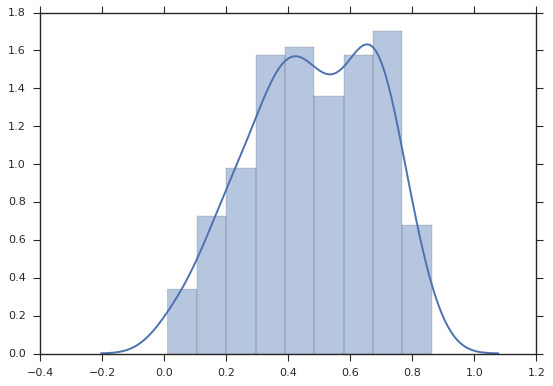

In [47]:
sns.distplot((idr_manifest.overlapping_pesudo_and_real / idr_manifest.pesudoreplicate_count).dropna())

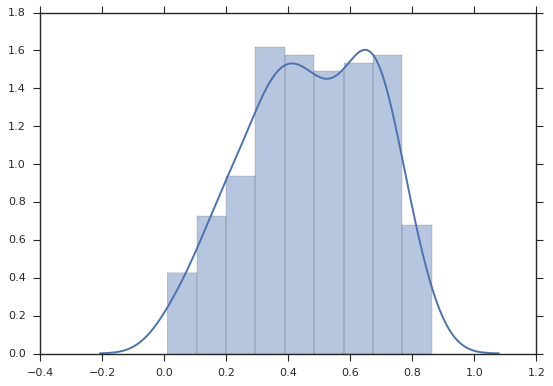

In [48]:
sns.distplot((idr_manifest.overlapping_real_and_pesudo / idr_manifest.pesudoreplicate_count).dropna())

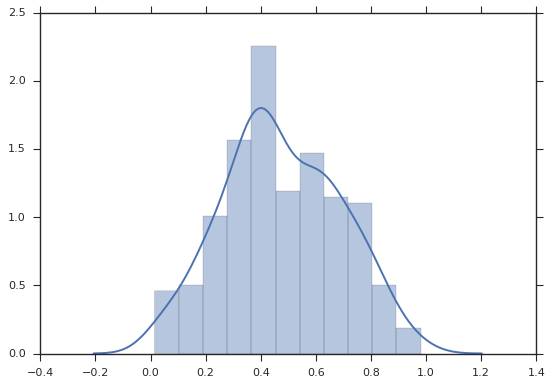

In [49]:
sns.distplot((idr_manifest.overlapping_pesudo_rep1_and_rep2 / idr_manifest.rep1_count))

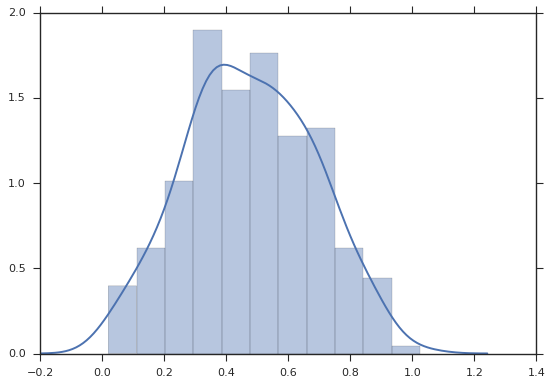

In [50]:
sns.distplot((idr_manifest.overlapping_pesudo_rep2_and_rep1 / idr_manifest.rep2_count))

# What does SLBP look like

In [51]:
def add_order(bedtool):
    for x, interval in enumerate(bedtool):
        interval.append(x)
        yield interval

In [52]:
bedtool = pybedtools.BedTool(idr_manifest[idr_manifest.uID == "262"]['replicate_sig'].iloc[0])
bedtool = pybedtools.BedTool(add_order(bedtool)).saveas()
bedtool_sort_order = bedtool.to_dataframe(names=range(15))

In [53]:
genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_genes.bed")
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [54]:
overlapping_genes = bedtool.intersect(genes, s=True, wo=True).saveas()
overlapping_genes_df = overlapping_genes.to_dataframe(names=range(22))
overlapping_genes_df['gene_name'] = overlapping_genes_df[18].apply(lambda x: gene_id_to_name[x])
overlapping_genes_df['is_histone'] = overlapping_genes_df.gene_name.apply(lambda x: "HIST" in x)

In [55]:
grouped_overlapping_df = overlapping_genes_df.groupby([0,1,2]).first()
grouped_overlapping_df = grouped_overlapping_df.sort_values(14)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).sum()


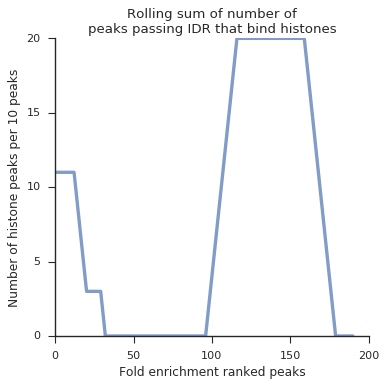

In [56]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "rolling_mean.svg"), figsize=(5 * num_cols,5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.plot(pd.rolling_sum(grouped_overlapping_df.is_histone, window=20).dropna().values, linewidth=3, alpha=.7)
    ax.set_ylabel("Number of histone peaks per 10 peaks")
    ax.set_title("Rolling sum of number of\npeaks passing IDR that bind histones")
    ax.set_xlabel("Fold enrichment ranked peaks")
    sns.despine(ax=ax)
    

# join IDR QC with ENCODE QC

In [57]:
idr_manifest[("peaks_submitable", "rep1")] = idr_manifest[("peaks_submitable", "rep1")].apply(lambda x: False if x.strip() == "FALSE" else True)

KeyError: ('peaks_submitable', 'rep1')

In [ ]:
passed_qc_idr_manifest = idr_manifest[idr_manifest[("peaks_submitable", "rep1")]]

In [ ]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_passed_qc.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Reproducablity Test")
    ax.set_title("Number of replicates\npassing reproducibility test")
    sns.despine(ax=ax)
    
    sns.factorplot(x='reproducibility_test', 
                   kind='count', 
                   data=passed_qc_idr_manifest, 
                   order=["pass", "borderline", "fail"],
                   ax=ax
                  )
    ax.set_ylabel("Number of Datasets")
    ax.set_xlabel("")

537 AGGF1 looks fine to be honest, may want to re-look at this as an honest to god false positive (or negative depending on how we are classifying)
668 PUS1 we shouldn't have submitted, not enough read depth probably I'll need to talk with Eric about this
617 TBERG, looks like its family mapping submittable, but we didn't call it as such.   I'll need to talk with Eric about this

In [ ]:
idr_manifest_passed = idr_manifest[idr_manifest.reproducibility_test != "fail"]
idr_manifest_failed = idr_manifest[idr_manifest.reproducibility_test == "fail"]

tp = len(idr_manifest_passed[idr_manifest_passed[("peaks_submitable", "rep1")]]) * 1.0
fp = len(idr_manifest_passed[~idr_manifest_passed[("peaks_submitable", "rep1")]]) * 1.0

fn = len(idr_manifest_failed[idr_manifest_failed[("peaks_submitable", "rep1")]]) * 1.0
tn = len(idr_manifest_failed[~idr_manifest_failed[("peaks_submitable", "rep1")]]) * 1.0


In [ ]:
print tp, fp, fn, tn

# Saturation Test

I'm going to ignore this, its the old peaks not sequenced deeply enough, but saturated analysis, its no unnessessary

In [ ]:
dataset_qc = pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/encode_master_qc.csv")
dataset_qc['Usable Reads'] = dataset_qc['Usable Reads'].apply(lambda x: int(x.replace(",", "")))

In [ ]:
merged_data.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/merged_data.csv")

In [ ]:
small_merged_data = merged_data[merged_data.uID.isin(set(dataset_qc[dataset_qc['Usable Reads'] < 1000000].encode_id.astype(str).values))]

In [ ]:
def filter_data(interval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment
    return (float(interval[4]) > 3) and (float(interval[3]) > 5)

def filter_data_leneant(interval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment
    return (float(interval[4]) > 2) and (float(interval[3]) > 3)

In [ ]:
def saturation_rep1(row):
    downsampled_peaks = pybedtools.BedTool(row.clip_split_rep1)
    normal_peaks = pybedtools.BedTool(row['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'])
    normal_peaks_filtered = normal_peaks.filter(filter_data).saveas()
    num_normal_peaks = len(normal_peaks_filtered)
    downsampled_filtered_peaks = downsampled_peaks.filter(filter_data_leneant).saveas()
    num_overlapping_peaks = len(normal_peaks_filtered.intersect(downsampled_filtered_peaks, u=True, s=True))
    return num_overlapping_peaks / (num_normal_peaks * 1.0)

def saturation_rep2(row):
    downsampled_peaks = pybedtools.BedTool(row.clip_split_rep2)
    normal_peaks = pybedtools.BedTool(row['uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed'])
    normal_peaks_filtered = normal_peaks.filter(filter_data).saveas()
    num_normal_peaks = len(normal_peaks_filtered)
    downsampled_filtered_peaks = downsampled_peaks.filter(filter_data_leneant).saveas()
    num_overlapping_peaks = len(normal_peaks_filtered.intersect(downsampled_filtered_peaks, u=True, s=True))
    return num_overlapping_peaks / (num_normal_peaks * 1.0)

In [ ]:
hist_genes = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/RNA_type_analysis/genelists.HISTall", header=None,
              )

In [ ]:
foo = pybedtools.BedTool(small_merged_data[small_merged_data.uID == "262"].clip_split_rep1.values[0]).filter(filter_data).saveas()
foo = foo.intersect("/home/gpratt/clipper/clipper/data/regions/hg19_v19_genes.bed", wo=True)

In [ ]:
len(foo)

In [ ]:
foo = pybedtools.BedTool(small_merged_data[small_merged_data.uID == "262"]['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'].values[0]).filter(filter_data).saveas()
foo = foo.intersect("/home/gpratt/clipper/clipper/data/regions/hg19_v19_genes.bed", wo=True)
bar = foo.filter(lambda x: x[-4] in hist_genes[0].values).saveas()

In [ ]:
print len(foo), len(bar)

In [ ]:
foo = pybedtools.BedTool(small_merged_data[small_merged_data.uID == "262"]['uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed'].values[0]).filter(filter_data).saveas()
foo = foo.intersect("/home/gpratt/clipper/clipper/data/regions/hg19_v19_genes.bed", wo=True)
bar = foo.filter(lambda x: x[-4] in hist_genes[0].values).saveas()

In [ ]:
print len(foo), len(bar)

In [ ]:
small_merged_data['downsample_rep1'] = small_merged_data.apply(saturation_rep1, axis=1)
small_merged_data['downsample_rep2'] = small_merged_data.apply(saturation_rep2, axis=1)

In [ ]:
threshold = .8

In [ ]:
" ".join(small_merged_data[(small_merged_data.downsample_rep1 > threshold) & (small_merged_data.downsample_rep2 > threshold)].RBP.values)

In [ ]:
" ".join(small_merged_data[~((small_merged_data.downsample_rep1 > threshold) & (small_merged_data.downsample_rep2 > threshold))].RBP.values)

In [ ]:
def confusion_numbers(threshold):
    small_merged_data_passed = small_merged_data[(small_merged_data.downsample_rep1 > threshold) & (small_merged_data.downsample_rep2 > threshold)]
    small_merged_data_failed = small_merged_data[~((small_merged_data.downsample_rep1 > threshold) & (small_merged_data.downsample_rep2 > threshold))]

    tp = len(small_merged_data_passed[small_merged_data_passed.uID.isin(passed_qc)]) * 1.0
    fp = len(small_merged_data_passed[~small_merged_data_passed.uID.isin(passed_qc)]) * 1.0

    fn = len(small_merged_data_failed[small_merged_data_failed.uID.isin(passed_qc)]) * 1.0
    tn = len(small_merged_data_failed[~small_merged_data_failed.uID.isin(passed_qc)]) * 1.0
    
    return tp, fp, fn, tn

In [ ]:
true_positive_array = []
false_positive_array = []

for threshold in np.arange(0,1, .01):


    tp, fp, fn, tn = confusion_numbers(threshold)
    true_positive_rate = tp / (tp + fn)
    false_positive_rate = fp / (fp + tn)
    
    true_positive_array.append(true_positive_rate)
    false_positive_array.append(false_positive_rate)

In [ ]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_passed_qc.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.plot(false_positive_array, true_positive_array)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")

In [ ]:
confusion_numbers(.8)

In [ ]:
sns.set_style("ticks")

In [ ]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "short_peak_overlap.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.distplot(pd.concat([small_merged_data.downsample_rep1, small_merged_data.downsample_rep2]), 
                 bins=10, 
                 kde=False,
                ax=ax)
    ax.set_ylabel("Number of Datasets", fontsize=18)
    ax.set_xlabel("Fraction Overlapping", fontsize=18)
    ax.set_title("Overlap of downsampled\npeaks with all peaks", fontsize=18)
    sns.despine(ax=ax)
    ax.axvline(.8, color=".7", linestyle="--")
    [tick.set_fontsize(14) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(14) for tick in ax.get_yticklabels()]

I'll need to go back and look again somehow quantify?, but looking at the ones we failed and fail the low QC numbers they are all ones we didn't identify any real peaks.

The ones that passesed we were generally confused about and decided not to submit because we couldn't find any real signal.  Additionally some still wouldn't pass due to differences in sequencing depth (one dataset only had 30k reads or something).  But would pass the initial filter step.  

# This might still be useful, can't figure out whats going on with the code though

In [ ]:
# result = {}
# for name, row in df.iterrows():
#     encode_id = row['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'].split("_")[0]
#     try:
#         rep1 = pybedtools.BedTool(os.path.join(peaks_dir, (row['uID_01.basedon_uID_01.peaks.l2inputnormnew.bed.compressed.bed'])))
#         rep2 = pybedtools.BedTool(os.path.join(peaks_dir, (row['uID_02.basedon_uID_02.peaks.l2inputnormnew.bed.compressed.bed'])))
#         idr_peaks = pybedtools.BedTool("/home/gpratt/projects/encode/analysis/idr_analysis_score/{}.txt".format(encode_id))
#     except ValueError as e:
#         print e
#         continue
#     rep1_enriched = rep1.filter(filter_data).saveas()
#     rep2_enriched = rep2.filter(filter_data).saveas()
#     idr_peaks_filtered = idr_peaks.filter(lambda x: float(x.score) > 540).saveas()
    
#     overlapping_r1_r2 = rep1.intersect(rep2, s=True, u=True)
#     overlapping_r1_r2_enriched = overlapping_r1_r2.filter(filter_data).saveas()
    
#     result[encode_id] = {"rep1_enriched_peaks": len(rep1_enriched),
#                          "idr_peaks": len(idr_peaks),
#                          "rep1_rep2_overlap": len(overlapping_r1_r2),
#                          "rep1_rep2_overlap_enriched": len(overlapping_r1_r2_enriched),
#                          "rep1_enriched_with_idr": len(rep1_enriched.intersect(idr_peaks_filtered, u=True)),
#                          "overlapping_enriched_with_idr": len(overlapping_r1_r2_enriched.intersect(idr_peaks_filtered, u=True)) 
#                         }
    
# result = pd.DataFrame(result).T

# result['rep1_enriched_fraction'] = result.overlapping_enriched_with_idr / result.rep1_enriched_peaks
# result['overlapping_enriched_fraction'] = result.overlapping_enriched_with_idr / result.rep1_rep2_overlap_enriched
# with dataviz.Figure(os.path.join(img_dir, "overlapping_enriched.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
#     ax = fig.add_subplot(1,1,1)
#     dataviz.plot_cdf(result.overlapping_enriched_fraction, ax=ax)
#     ax.set_xlim(0,1)
#     sns.despine(ax=ax)

# with dataviz.Figure(os.path.join(img_dir, "overlapping_enriched.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
#     ax = fig.add_subplot(1,1,1)
#     dataviz.plot_cdf(result.rep1_enriched_fraction, ax=ax, linewidth=4, alpha=.7, color='k')
#     ax.set_xlim(0,1)
#     sns.despine(ax=ax)
#     ax.set_ylabel("Cumulative Fraction", fontsize=14)
#     ax.set_xlabel("Fraction of enriched\npeaks overlapping with IDR peaks", fontsize=14)

# with dataviz.Figure(os.path.join(img_dir, "enriched_scatter.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
#     ax = fig.add_subplot(1,1,1)
#     ax.scatter(result.rep1_enriched_peaks, result.rep1_enriched_fraction, color='k', alpha=.5)
#     sns.despine(ax=ax)
#     ax.set_ylim(0,1)
#     ax.set_xlabel("# of peaks stringently enriched above input\np-value <= $10^{-5}$, fold enrichment >= 3", fontsize=14)
#     ax.set_ylabel("Fraction oberved in IDR", fontsize=14)
#     ax.set_xlim(0,)
    
